# Detección de anomalías en un marco de auditoría continua

## 12. Datos desbalanceados - Modelos no supervisados - PyCaret

### 12.1. Split del dataset

Split del dataset para reservar un conjunto de datos para validación posterior al entrenamiento y desarrollo de los modelos.

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import os
import time
import joblib

# ! pip install pandas
# ! pip install numpy
# ! pip install pycaret==2.3.5
# ! pip install scipy==1.4.1
# ! pip install joblib
# ! pip install sklearn
# ! pip install hyperopt

In [2]:
# Filtro de warnings.
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Carga del dataset.
os.chdir('..')
df = pd.read_csv('df_preprocessed.csv')
df.head()

,day,hour,amount,idOrig,oldbalanceOrig,newbalanceOrig,idDest,oldbalanceDest,newbalanceDest,Cash_in,Cash_out,Debit,Payment,Transfer,isFraud,isFlaggedFraud
0,1,1,9839.64,0,170136.0,160296.36,6353307,0.0,0.0,0,0,0,1,0,0,0
1,1,1,1864.28,1,21249.0,19384.72,6353308,0.0,0.0,0,0,0,1,0,0,0
2,1,1,181.00,2,181.0,0.00,6353309,0.0,0.0,0,0,0,0,1,1,0
3,1,1,181.00,3,181.0,0.00,6353310,21182.0,0.0,0,1,0,0,0,1,0
4,1,1,11668.14,4,41554.0,29885.86,6353311,0.0,0.0,0,0,0,1,0,0,0


In [4]:
# Split del dataset para reservar un conjunto de validación.
from sklearn.model_selection import train_test_split
df_training, df_validation = train_test_split(df, test_size = 0.2, random_state = 42, shuffle = True, stratify = np.array(df['isFraud']))

In [5]:
# Control de frecuencias de clases.
print('Proporcion de clases para dataset de training: %.4f' % (df_training['isFraud'].value_counts()[1] / df_training['isFraud'].value_counts()[0]))
print('Proporcion de clases para dataset de validación: %.4f' % (df_validation['isFraud'].value_counts()[1] / df_validation['isFraud'].value_counts()[0]))

Proporcion de clases para dataset de training: 0.0013
Proporcion de clases para dataset de validación: 0.0013


### 12.2. Balanceo de datos

Para el balanceo de datos, se recurre a una técnica híbrida:
- Por un lado, se submuestrean los registros de la clase mayoritaria, utilizando muestreo sin reposición.
- Por otro lado, se sobremuestrean los registros de la clase minoritaria, utilizando muestreo con reposición.
- Se recurre a un valor de k, que representa el factor de muestreo. A mayor k, mayor es la participación de casos de fraude dentro del nuevo dataset.

In [6]:
# Función para el balanceo de datos.
from sklearn.utils import resample

def balancing(X, y, k):
    # X = dataframe; y = series; k = float
    
    # Submuestreo de la clase mayoritaria.
    index_majority_downsampled = resample(X[y == 0], 
                                       replace = False,
                                       n_samples = int(len(X[y == 0]) * (1 - k)),
                                       random_state = 42).index
    
    # Sobremuestreo de la clase minoritaria.
    index_minority_oversampled = resample(X[y == 1], 
                                       replace = True,
                                       n_samples = int(len(X[y == 1]) * (1 + k)),
                                       random_state = 42).index
    
    indexes = list(index_majority_downsampled) + list(index_minority_oversampled)
    
    return indexes

### 11.3. Detección de anomalías utilizando la librería PyCaret

https://towardsdatascience.com/unsupervised-anomaly-detection-in-python-f2e61be17c2b

https://www.oreilly.com/library/view/hands-on-unsupervised-learning/9781492035633/ch04.html

https://pycaret.org/

#### 11.3.1. Optimización de hiperparámetros

In [7]:
# Importación de librerías.
import os
import json
from datetime import datetime
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, accuracy_score
from hyperopt import fmin, hp, tpe, space_eval, Trials
from pycaret.anomaly import *

# Definición de la función objetivo.
def objective_func(search_space):

    global counter, scorings, df_subset
    start_time = time.time()
    counter += 1    
    
    kfold = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)
    
    scores = {'accuracy' : [],
              'recall' : [],
              'precision' : [],
              'f1_score' : [],
              'roc_auc' : []
             }
    
    scorings_trial = {}

    for train, test in kfold.split(df_subset, y = df_subset.iloc[:, -2]):
        
        X_train = df_subset.iloc[train, :]
        X_test = df_subset.iloc[test, :]
        y_train = df_subset.iloc[train, -2]
        y_test = df_subset.iloc[test, -2]
        
        indexes_train = balancing(X_train, y_train, 0.8)
        indexes_test = balancing(X_test, y_test, 0.8)
        
        X_train = X_train.loc[indexes_train, :]
        X_test = X_test.loc[indexes_test, :]
        y_train = y_train.loc[indexes_train]
        y_test = y_test.loc[indexes_test]       
        
        anom = setup(data = X_train,
                     ignore_features = ['isFraud', 'isFlaggedFraud'], 
                     categorical_features = ['Cash_in', 'Cash_out', 'Debit', 'Payment', 'Transfer'],
                     normalize = True,
                     normalize_method = search_space['scaler'],
                     silent = True,
                     use_gpu = True,
                     verbose = False,
                     session_id = 42, 
                    )
        
        iforest = create_model(model = search_space['model'], fraction = search_space['fraction'], verbose = False)
        
        predictions = predict_model(iforest, data = X_test)
        
        y_pred = predictions.loc[:, 'Anomaly']
        
        scores['accuracy'].append(accuracy_score(y_true = y_test, y_pred = y_pred))
        scores['recall'].append(recall_score(y_true = y_test, y_pred = y_pred))
        scores['precision'].append(precision_score(y_true = y_test, y_pred = y_pred))
        scores['f1_score'].append(f1_score(y_true = y_test, y_pred = y_pred))
        scores['roc_auc'].append(roc_auc_score(y_true = y_test, y_score = y_pred))
    
    scorings_trial['trial'] = counter
    scorings_trial['search_space'] = str(search_space)

    for score in scores:
        scorings_trial[score + '_mean'] = np.mean(scores[score])
        scorings_trial[score + '_std'] = np.std(scores[score])

    loss = 1 - scorings_trial['f1_score_mean'] + scorings_trial['f1_score_std']

    scorings.append(scorings_trial)
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Loss: %.4f | Elapsed_time: %.4f seconds' % (counter, loss, elapsed_time))
    
    return loss

# Función para la impresión de resultados.
def hyperopt_printer(trials):
    print('\nBest Trial:')
    print('Trial ID :', trials.best_trial['tid'])
    print('Loss :', trials.best_trial['result']['loss'])
    print('Params :', space_eval(search_space, best_params), end = '\n\n')

# Función para exportación de resultados a formato JSON.
def json_export(scorings):
    try:
        os.mkdir('hyperopt_optimizations')
    except:
        None

    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M%S")
    path = os.getcwd() + '\hyperopt_optimizations\\'
    filename = 'Opt_' + dt_string + '.json'

    f = open(path + filename, 'w')
    json.dump(scorings, f)
    f.close()
    print('Json file: ' + dt_string + '.json', end = '\n\n')

# Función para la obtención de resultados en formato tabla para visualizar scorings y desvios estándar.
def scorings_to_df(scorings):
    scorings_df = pd.DataFrame(columns = list(scorings[0].keys()))
    for scoring in scorings:
        scorings_df = scorings_df.append(scoring, ignore_index = True)

    print('Scoring details:', end = '\n\n')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):  # more options can be specified also
        print(scorings_df)

    return scorings_df

In [9]:
# Espacio de búsqueda.
sss = StratifiedShuffleSplit(n_splits = 1, random_state = 42, train_size = 0.1)
for a, b in sss.split(df_training, df_training.iloc[:, -2]):
    df_subset = df_training.iloc[a, :]
scaler = ['zscore', 'minmax', 'maxabs', 'robust']
models = ['cluster', 'iforest', 'histogram', 'knn', 'lof', 'pca', 'mcd'] # abod, svm, cof, sos
search_space = {'scaler' : hp.choice('scaler', scaler),
                'model' : hp.choice('model', models),
                'fraction' : hp.randint('fraction', 1 , 50) / 100
               }

# Ejecución del optimizador.
counter = -1
scorings = []
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, space = search_space, algo = tpe.suggest, max_evals = 100, trials = trials, rstate = rstate)

Trial: 0 | Loss: 0.9504 | Elapsed_time: 13.5497 seconds
Trial: 1 | Loss: 0.9202 | Elapsed_time: 13.2490 seconds                          
Trial: 2 | Loss: 0.9141 | Elapsed_time: 37.1153 seconds                          
Trial: 3 | Loss: 0.9283 | Elapsed_time: 13.2255 seconds                          
Trial: 4 | Loss: 0.9520 | Elapsed_time: 94.2063 seconds                          
Trial: 5 | Loss: 0.9261 | Elapsed_time: 13.8752 seconds                            
Trial: 6 | Loss: 0.8610 | Elapsed_time: 72.4813 seconds                            
Trial: 7 | Loss: 0.9614 | Elapsed_time: 18.9507 seconds                            
Trial: 8 | Loss: 0.9209 | Elapsed_time: 13.3764 seconds                            
Trial: 9 | Loss: 0.9396 | Elapsed_time: 13.2598 seconds                          
Trial: 10 | Loss: 0.9485 | Elapsed_time: 21.7013 seconds                          
Trial: 11 | Loss: 0.9074 | Elapsed_time: 13.3736 seconds                          
Trial: 12 | Loss: 0.9180 | Elaps

In [11]:
# Impresión de resultados.
hyperopt_printer(trials)
scorings_df = scorings_to_df(scorings)


Best Trial:
Trial ID : 70
Loss : 0.8368820396833657
Params : {'fraction': 0.01, 'model': 'lof', 'scaler': 'maxabs'}

Scoring details:

   trial                                       search_space accuracy_mean accuracy_std recall_mean recall_std precision_mean precision_std f1_score_mean f1_score_std roc_auc_mean roc_auc_std
0      0  {'fraction': 0.32, 'model': 'pca', 'scaler': '...      0.686495     0.002621    0.749484   0.032275       0.026988      0.001306      0.052099      0.00251     0.717623     0.01665
1      1  {'fraction': 0.17, 'model': 'histogram', 'scal...      0.836782      0.00338    0.662344   0.035016       0.045636      0.003059      0.085387     0.005637     0.750576    0.018473
2      2  {'fraction': 0.15, 'model': 'iforest', 'scaler...      0.853447     0.002608    0.666564   0.056017       0.050988        0.0048      0.094729     0.008848     0.761091    0.028973
3      3  {'fraction': 0.07, 'model': 'histogram', 'scal...      0.924618     0.001198    0.268148  

#### 11.3.2. Evaluación sobre el conjunto de validación

Best Trial:
Trial ID : 70
Loss : 0.8368820396833657
Params : {'fraction': 0.01, 'model': 'lof', 'scaler': 'maxabs'}

In [7]:
%%time
# Importación de librerías.
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, accuracy_score
from pycaret.anomaly import *

# Espacio de búsqueda.
search_space = {'fraction' : 0.01, 'model' : 'lof', 'scaler' : 'maxabs'}

# Ingeniería de predictores.
X_train = df_training
y_train = df_training['isFraud']
X_test = df_validation
y_test = df_validation['isFraud']

# Balanceo de datos.
indexes = balancing(X_train, y_train, 0.8)
X_balanced = X_train.loc[indexes, :]
y_balanced = y_train.loc[indexes]

# Entrenamiento del modelo.
anom = setup(data = X_balanced,
             ignore_features = ['isFraud', 'isFlaggedFraud'], 
             categorical_features = ['Cash_in', 'Cash_out', 'Debit', 'Payment', 'Transfer'],
             normalize = True,
             normalize_method = search_space['scaler'],
             silent = True,
             use_gpu = True,
             verbose = False,
             session_id = 42, 
            )

CPU times: total: 1min 54s
Wall time: 2min 1s


Se utiliza el modelo "iforest" en virtud de problemas de rendimiento del modelo LOF.

In [8]:
%%time
# Desarrollo del modelo.
model = create_model(model = 'iforest', fraction = search_space['fraction'], verbose = True)
predictions = predict_model(model, data = X_test)
y_pred = predictions.loc[:, 'Anomaly']

# Obtención de métricas.
print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

Recall: 0.1223
Precision: 0.0183
AUC: 0.5569
Accuracy: 0.9904
F1-Score: 0.0318
CPU times: total: 2min 19s
Wall time: 2min 18s


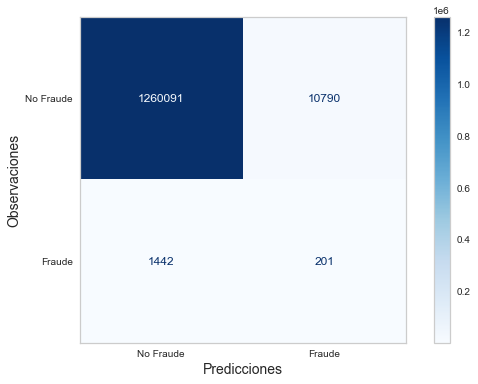

In [33]:
# Matriz de confusión.
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = ['No Fraude', 'Fraude'])
filename = 'pycaret_balanced'

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp.plot(ax = ax, values_format = 'd', cmap = 'Blues')
ax.set_xlabel(xlabel = 'Predicciones', fontdict = {'fontsize' : 14, 'family' : 'sans-serif'})
ax.set_ylabel(ylabel = 'Observaciones', fontdict = {'fontsize' : 14, 'family' : 'sans-serif'})
plt.grid(False)
plt.savefig('.//figures//' + filename + '_confusion_matrix.png')

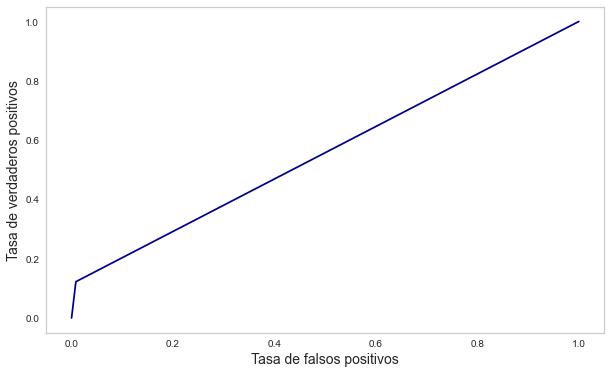

In [34]:
# Curva ROC.
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay

# Obtención de la curva ROC
fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_pred)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
filename = 'pycaret_balanced'

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp.plot(ax = ax, c = 'darkblue')
ax.set_xlabel(xlabel = 'Tasa de falsos positivos', fontdict = {'fontsize' : 14, 'family' : 'sans-serif'})
ax.set_ylabel(ylabel = 'Tasa de verdaderos positivos', fontdict = {'fontsize' : 14, 'family' : 'sans-serif'})
plt.grid(False)
plt.savefig('.//figures//' + filename + '_roc_curve.png')

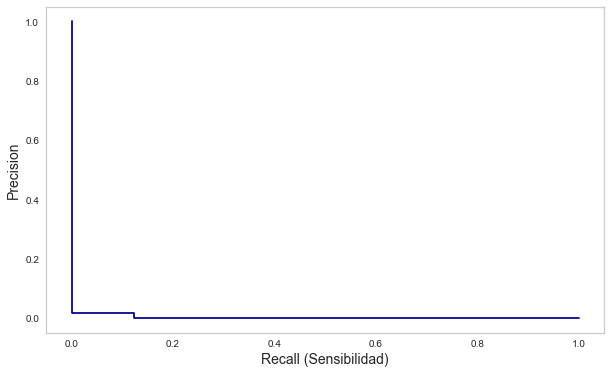

In [35]:
# Curva Precision-Recall.
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Obtención de la curva Recall - Precision
prec, recall, _ = precision_recall_curve(y_true = y_test, probas_pred = y_pred)
disp = PrecisionRecallDisplay(precision = prec, recall = recall)
filename = 'pycaret_balanced'

fig = plt.figure(figsize = (10,6))
ax = plt.axes()
disp.plot(ax = ax, c = 'darkblue')
ax.set_xlabel(xlabel = 'Recall (Sensibilidad)', fontdict = {'fontsize' : 14, 'family' : 'sans-serif'})
ax.set_ylabel(ylabel = 'Precision', fontdict = {'fontsize' : 14, 'family' : 'sans-serif'})
plt.grid(False)
plt.savefig('.//figures//' + filename + '_precision_recall.png')

In [41]:
# Exportación a csv.
y_test.to_csv('pycaret_ytest_balanced.csv')
y_pred.to_csv('pycaret_ypred_balanced.csv')